# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


# Computing the camera calibration using chessboard images
Images or videos captured by a camera are typically distorted by the lens. Using a image like that would cause problems when trying to calculate the curvature or the car's offset to the center line. That's why it is important to undistort images first. For that a distortion matrix is calculated based on several images of a chessboard captured by the same camera. The matrix can then be used to undistort other images.

In [7]:
import os
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import collections
from itertools import chain
from functools import reduce
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip

%matplotlib inline

In [8]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    return mtx, dist

def camera_setup(calibration_path):
    cal_images = glob.glob(calibration_path)
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist

In [9]:
camera_file = '../camera_cal/camera_file'
print('Calibrating camera ...')
cam_mtx, cam_dist = camera_setup('../camera_cal/calibration*.jpg')
np.savez_compressed(camera_file, cam_mtx=cam_mtx, cam_dist=cam_dist)
print('Calibration completed')

Calibrating camera ...
Calibration completed


In [10]:
print('Loading camera data from', camera_file)
data = np.load(camera_file + '.npz')
cam_mtx = data['cam_mtx']
cam_dist = data['cam_dist']
print('Camera data loaded')

Loading camera data from ../camera_cal/camera_file
Camera data loaded


---
# Image Processing Pipeline 

In the following section, the different steps of the lane detection pipeline are described in the same order as they are apply in the algorithm.


## Applying distort correction.
The first step is to remove the lens distortion by applying the calculated distortion matrix. I apply the distortion correction to one of the test images to test how it works:

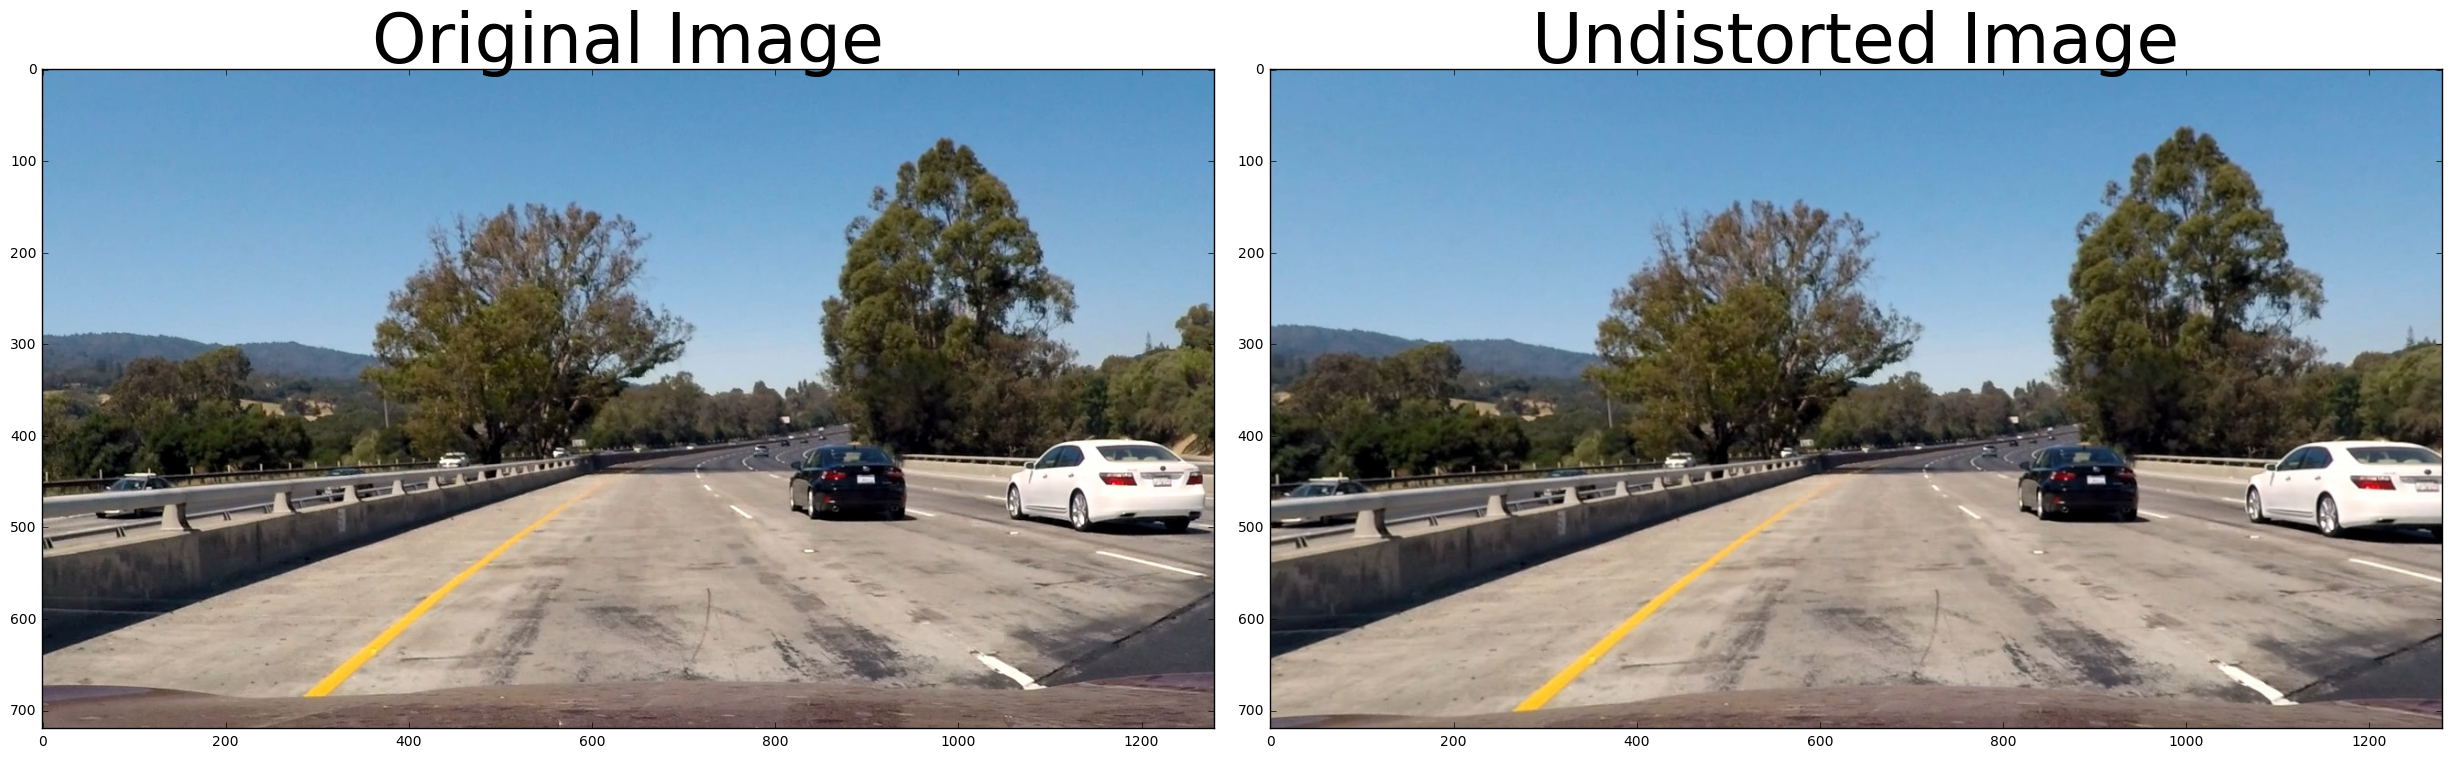

In [18]:
def cal_undistort(img_name, mtx, dist):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return img, undist

image_name = '../test_images/test1.jpg'

orig_img, undistorted_img = cal_undistort(image_name, cam_mtx, cam_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Creating a thresholded binary image using color transforms, gradients and other methods 
After the lens distortion has been removed, a binary image will be created, containing pixels which are likely part of a lane. Therefore the result of multiple techniques are combined by a bitwise and operator. Finding good parameters for the different techniques like threshold values was quite challenging. I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines #156 through #177 in [advanced-line-detection.py](advanced-line-detection.py). 

In [19]:
def abs_sobel_threshold(img, orient, sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def mag_thresh(img, sobel_kernel, mag_thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel, thresh):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_channel = hsv[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary


def find_edges(image, mask_half=False):
    s = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 130, 255, cv2.THRESH_BINARY)
    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_one = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_one)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_one = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)
    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary,
                        cv2.bitwise_or(mask_one, mask_two)), 0, 1).astype('uint8')
    return combined_binary


 Here's example of my outputs for this step for test images.

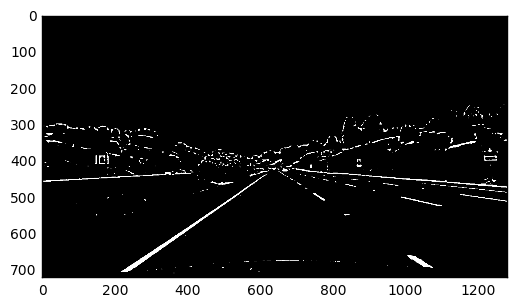

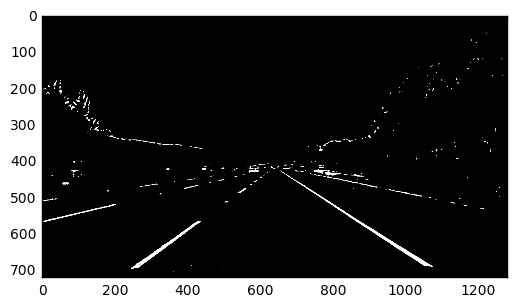

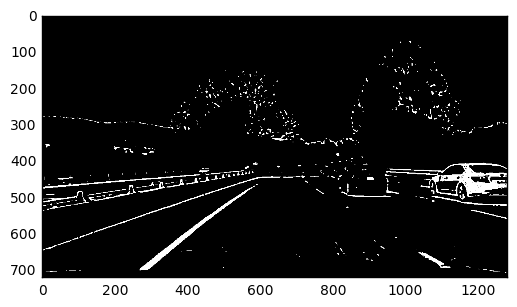

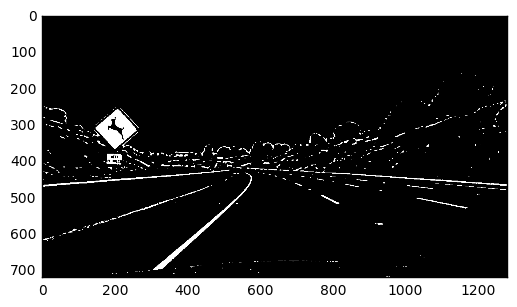

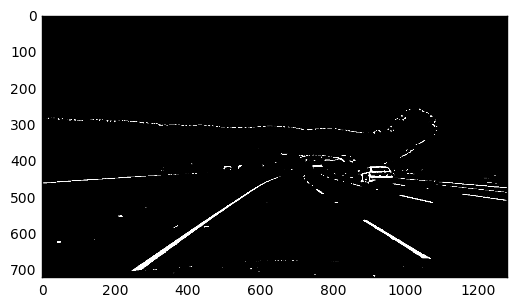

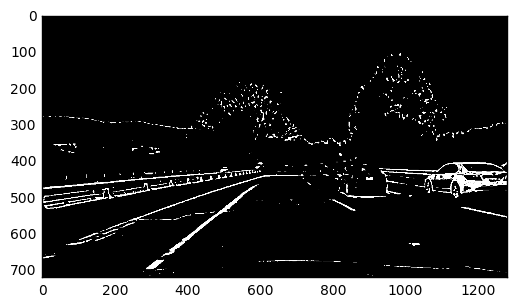

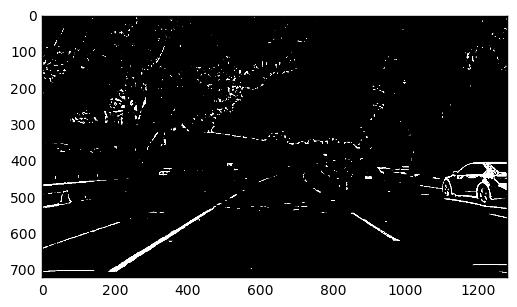

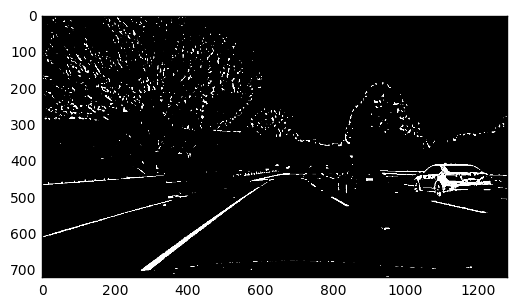

In [16]:
images = glob.glob('../test_images/*.jpg')
for i, name in enumerate(images):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    img = find_edges(img)
    plt.imshow(img, cmap='gray')
    plt.show()

 ## Performing a perspective transform 
The code for perspective transform includes functions`get_perspective_transform()` (lines #70 through #96) and `find_perspective_points` (lines #100 throught #153) in the file [advanced-line-detection.py](advanced-line-detection.py). I chose the hardcode the default source and destination points in the following manner:

In [24]:
img_name = '../test_images/straight_lines2.jpg'
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_size = (img.shape[0], img.shape[1])
print(img_size)
src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                [705. /1280.*img_size[1], 455./720.*img_size[0]],
                [1130./1280.*img_size[1], 720./720.*img_size[0]],
                [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                [1000./1280.*img_size[1], 100./720.*img_size[0]],
                [1000./1280.*img_size[1], 720./720.*img_size[0]],
                [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

print('souce',src)
print('destination', dst)

(720, 1280)
souce [[  585.   455.]
 [  705.   455.]
 [ 1130.   720.]
 [  190.   720.]]
destination [[  300.   100.]
 [ 1000.   100.]
 [ 1000.   720.]
 [  300.   720.]]


This resulted in the following source and destination points:

Source | Destination
-------|-----------
585, 455 |	300, 100
705, 455 |	1000, 100
1130, 720 |	1000, 720
190, 720 |	300,  720

In case dynamically computed using the hough transform computation fails to detect the lane markers, the hardcoded set of source points is used.

In [25]:
def get_perspective_transform(image, display=True):
    img_size = image.shape
    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)

    if display:
        plt.rcParams["figure.figsize"] = (24,18)
        plt.subplot(1,2,1)
        plt.hold(True)
        plt.imshow(image, cmap='gray')
        colors = ['r+','g+','b+','w+']
        for i in range(4):
            plt.plot(src[i,0],src[i,1],'ro')
        im2 = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)
        plt.hold(True)
        plt.imshow(im2)        
        for i in range(4):
            plt.plot(dst[i,0],dst[i,1],'ro')
        plt.show()
        
    return warp_m, warp_minv


I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


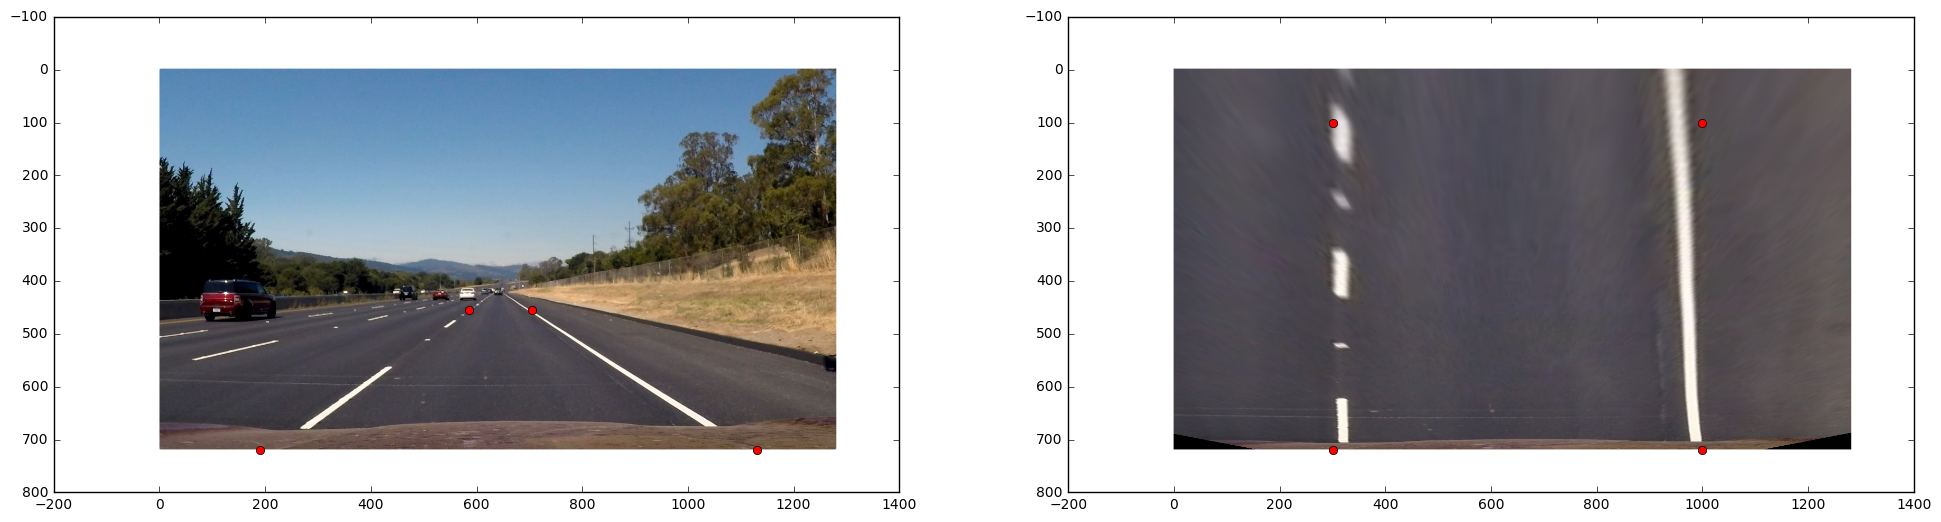

In [28]:
warp_m, warp_minv = get_perspective_transform(img)

## Identifying lane-line pixels and fitting their positions with a polynomial

The lane detection could be performed using two methods: histogram and masking. 

The histogram method is based on computing the lanes base points of the lanes using function `histogram_base_points` (lines #334 through #348) in the file [advanced-line-detection.py](advanced-line-detection.py). The `find_peaks_cwt` function from the `scipy.signal` is used to identify the peaks in the histogram. Once the base points are found, a sliding window method is used to extract the lane pixels. This can be seen in the `sliding_window` function in lines #294-#332. The algorithm splits the image into a number of horizontal bands (10 by default).

The masking method is implemented in the `detect_from_mask` method defined in lines #268-#275. The algorithm uses the mask generated during the histogram method to remove irrelevant pixels and then uses all non-zero pixels found in the region of interest with the add_lane_pixels method to compute the polynomial describing the lane.

A sanity check based on the radius of curvature of the lanes is used to assess the results of lane detection. If two many frames fail the sanity check, the algorithm reverts to the histogram method until the lane is detected again.

## Computing radius of curvature and vehicle position on the lane

With pixels assigned to each lane, a second order polynomials can be fitted.  The polynomials are used to calculate the curvature of the lane and the relative offset from the car to the center line. The radius of curvature is computed in the `compute_rad_curv` method of the `Lane` class in lines #247-252. The pixel values of the lane are scaled into meters using the scaling factors defined as follows:

In [29]:
# Meters per pixel density
ym_per_pix = 30/720
xm_per_pix = 3.7/700

def compute_rad_curv(xvals, yvals):
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad

he position of the vehicle is computed by the code in lines 455-456. The camera is assumed to be centered in the vehicle and checks how far the midpoint of the two lanes is from the center of the image.

In [ ]:
middle = (left_fitx[-1] + right_fitx[-1])//2
veh_pos = image.shape[1]//2
dx = (veh_pos - middle)*xm_per_pix

---
# Discussion

The proposed pipeline is able to detect and track the lanes reliably in the project video. When reversing the warping/edge detection, it also worked well for the challenge video. The main issue with the challenge video was lack of contrast and false lines.

I think that the pipeline performance could be improved by applying temporal processing since the lane parameters do not change radically between frames. 

The gradient method faces problems under different illumination color temperatures, such as evening sun or artificial lighting conditions. A better method that will continuously compute the best weighting vector based on prior frames could be used. This was not implemented due to time constraints. However, implementing such a method would make the pipeline a lot more robust to change in contrast and illumination.